# Toy Models of Superposition

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/tms.ipynb)

Let's run through an example using Anthropic's toy models of superposition. 

This example is mostly to test that our SGLD estimator is working as expected and to figure out how to integrate this in an SGD setting.

Credits: [Chen et al. (2023)](https://arxiv.org/abs/2310.06301).

## Set-up
### Imports

In [ ]:
%pip install devinterp matplotlib scipy pyyaml==6.0.1

In [16]:
import os
from typing import Iterable, Optional

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import yaml
import itertools
from torch.utils.data import TensorDataset
from torch.nn import functional as F
import seaborn as sns

from devinterp.zoo.tms import ToyAutoencoder, SyntheticBinaryValued
from devinterp.slt.cov import BetweenLayerCovarianceAccumulator, CovarianceAccumulator
from devinterp.slt.llc import estimate_learning_coeff_with_summary
from devinterp.optim.sgld import SGLD

### Environmental variables

In [5]:
torch.manual_seed(1)

DEVICE = os.environ.get(
    "DEVICE",
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu",
)
DEVICE = torch.device(DEVICE)
NUM_CORES = int(os.environ.get("NUM_CORES", 1))

### K-gon Plotting Utils

In [6]:
def generate_2d_kgon_vertices(k, rot=0., pad_to=None, force_length=0.9):
    """Set the weights of a 2D k-gon to be the vertices of a regular k-gon."""
    # Angles for the vertices
    theta = np.linspace(0, 2*np.pi, k, endpoint=False) + rot

    # Generate the vertices
    x = np.cos(theta)
    y = np.sin(theta)
    result = np.vstack((x, y))

    if pad_to is not None and k < pad_to:
        num_pad = pad_to - k
        result = np.hstack([result, np.zeros((2, num_pad))])
        
    return (result * force_length)

def generate_init_param(m, n, init_kgon, prior_std=1., no_bias=True, init_zerobias=True, seed=0, force_negb=False, noise=0.01):
    np.random.seed(seed)
    
    if init_kgon is None or m != 2:
        init_W = np.random.normal(size=(m, n)) * prior_std
    else:
        assert init_kgon <= n
        rand_angle = np.random.uniform(0, 2 * np.pi, size=(1,))
        noise = np.random.normal(size=(m, n)) * noise
        init_W = generate_2d_kgon_vertices(init_kgon, rot=rand_angle, pad_to=n) + noise
    
    if no_bias:
        param = {"W": init_W}
    else:
        init_b = np.random.normal(size=(n, 1)) * prior_std
        if force_negb:
            init_b = -np.abs(init_b)
        if init_zerobias:
            init_b = init_b * 0
        param = {
            "W": init_W, 
            "b": init_b
        }
    return param

In [7]:
def plot_polygon(
    W: torch.Tensor,
    b=None,
    ax=None,
    ax_bias=None,
    ax_wnorm=None,
    hull_alpha=0.3,
    dW=None,
    dW_scale=0.3,
    orderb=True,
):
    """Credits: Edmund Lau"""
    if ax is None:
        if W.shape[0] == 2:
            fig, ax = plt.subplots(1, 1)
        elif W.shape[0] == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")

    if W.shape[0] == 2:  # 2D case
        # Compute the norms of the columns
        norms = np.linalg.norm(W, axis=0)

        # Normalize a copy of the vectors for angle calculations
        W_normalized = W / norms

        # Compute angles from the x-axis for each vector
        angles = np.arctan2(W_normalized[1, :], W_normalized[0, :])

        # Sort the columns of W by angles
        order = np.argsort(angles)
        W_sorted = W[:, order]

        # Plot the origin
        ax.scatter(0, 0, color="red")

        # Plot the vectors
        for i in range(W_sorted.shape[1]):
            ax.quiver(
                0,
                0,
                W_sorted[0, i],
                W_sorted[1, i],
                angles="xy",
                scale_units="xy",
                scale=1,
                width=0.003,
            )
        if dW is not None:
            dW = -dW_scale * dW / np.max(np.linalg.norm(dW, axis=0))
            for col in range(W.shape[1]):
                ax.quiver(
                    W[0, col],
                    W[1, col],
                    dW[0, col],
                    dW[1, col],
                    angles="xy",
                    scale_units="xy",
                    scale=1,
                    color="r",
                    width=0.005,
                )

        # Connect the vectors to form a polygon
        polygon = np.column_stack((W_sorted, W_sorted[:, 0]))
        ax.plot(polygon[0, :], polygon[1, :], alpha=0.5)

        # Plot the convex hull
        hull = ConvexHull(W.T)
        vs = list(hull.vertices) + [hull.vertices[0]]
        ax.plot(W[0, vs], W[1, vs], "r--", alpha=hull_alpha)

        # Set the aspect ratio of the plot to equal to ensure that angles are displayed correctly
        ax.set_aspect("equal", adjustable="box")

    elif W.shape[0] == 3:  # 3D case
        # Plot the origin
        ax.scatter([0], [0], [0], color="red")

        # Plot the vectors
        for i in range(W.shape[1]):
            ax.plot([0, W[0, i]], [0, W[1, i]], [0, W[2, i]], "b-")

        # Plot the convex hull
        hull = ConvexHull(W.T)
        for s in hull.simplices:
            s = np.append(s, s[0])  # Here we cycle back to the first coordinate
            ax.plot(W[0, s], W[1, s], W[2, s], "r--", alpha=hull_alpha)
    else:
        raise ValueError("W must have either 2 or 3 rows")

    if b is not None and ax_bias is not None:
        b_plot = np.ravel(b)
        if orderb:
            b_plot = b_plot[order]
        bar_colors = ["r" if val < 0 else "b" for val in b_plot]
        yticks = np.array(range(1, len(b_plot) + 1))
        ax_bias.barh(
            yticks - 0.4,
            np.abs(b_plot),
            height=0.4,
            color=bar_colors,
            align="edge",
        )
        ax_bias.set_yticks(yticks)
        ax_bias.yaxis.tick_right()
        ax_bias.tick_params(axis="y", labelsize="x-small")
        ax_bias.tick_params(axis="x", labelsize="x-small")

    if ax_wnorm is not None:
        yticks = np.array(range(1, W.shape[1] + 1))
        wnorms = np.linalg.norm(W, axis=0)
        if orderb:
            wnorms = wnorms[order]
        ax_wnorm.barh(yticks, width=wnorms, height=0.4, color="black", alpha=0.9, align="edge")
    return ax


def plot_polygons(Ws, axes=None):
    if axes is None:
        fig, axes = plt.subplots(1, len(Ws), figsize=(15, 4))

    for ax, W in zip(axes, Ws):
        plot_polygon(W, ax=ax)


def plot_losses_and_polygons(steps, losses, highlights, Ws):
    fig = plt.figure(figsize=(15, 6))

    gs = fig.add_gridspec(2, len(Ws))
    ax_losses = fig.add_subplot(gs[1, :])
    ax_polygons = []

    max_x, min_x = max([np.max(W[0]) for W in Ws]), min([np.min(W[0]) for W in Ws])
    max_y, min_y = max([np.max(W[1]) for W in Ws]), min([np.min(W[1]) for W in Ws])

    for i in range(len(Ws)):
        ax = fig.add_subplot(gs[0, i], adjustable='box') 
        ax.set_aspect('equal')
        ax_polygons.append(ax)
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)

    ax_losses.plot(steps, losses)
    ax_losses.set_xlabel("Step")
    ax_losses.set_ylabel("Loss")
    ax_losses.set_xscale("log")
    ax_losses.set_yscale("log")

    for i, step in enumerate(highlights):
        ax_losses.axvline(step, color="gray", linestyle="--")

    plot_polygons(Ws, ax_polygons)

    plt.suptitle("Loss and Weight snapshots")
    plt.tight_layout()


### Training loop

In [8]:
def create_and_train(
    m: int,
    n: int,
    num_samples: int,
    batch_size: Optional[int] = 1,
    num_epochs: int = 100,
    lr: float = 0.001,
    log_ivl: Iterable[int] = [],
    device=DEVICE,
    momentum=0.9,
    weight_decay=0.0,
    init_kgon=None,
    no_bias=False,
    init_zerobias=False,
    prior_std=10.,
    seed=0
):
    model = ToyAutoencoder(m, n, final_bias=True)

    init_weights = generate_init_param(n, m, init_kgon, no_bias=no_bias, init_zerobias=init_zerobias, prior_std=prior_std, seed=seed)
    model.embedding.weight.data = torch.from_numpy(init_weights["W"]).float()
    
    if "b" in init_weights:
        model.unembedding.bias.data = torch.from_numpy(init_weights["b"].flatten()).float()

    dataset = SyntheticBinaryValued(num_samples, m, 1)
    batch_size = batch_size

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    logs = pd.DataFrame([{"loss": None, "acc": None, "step": step} for step in log_ivl])

    model.to(device)
    weights = []

    def log(step):
        loss = 0.0
        acc = 0.0
        length = 0

        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(device)
                outputs = model(batch)
                loss += criterion(outputs, batch).item()
                acc += (outputs.round() == batch).float().sum().item()
                length += len(batch)

        loss /= length
        acc /= length

        logs.loc[logs["step"] == step, ["loss", "acc"]] = [loss, acc]
        weights.append({k: v.cpu().detach().clone().numpy() for k, v in model.state_dict().items()})

    step = 0
    log(step)

    for epoch in tqdm(range(num_epochs), desc="Training"):
        for batch in dataloader:
            batch = batch.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch)
            loss = criterion(outputs, batch)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            step += 1

            if step in log_ivl:
                log(step)

    return logs, weights

## Training

Training: 100%|██████████| 20000/20000 [07:52<00:00, 42.35it/s]


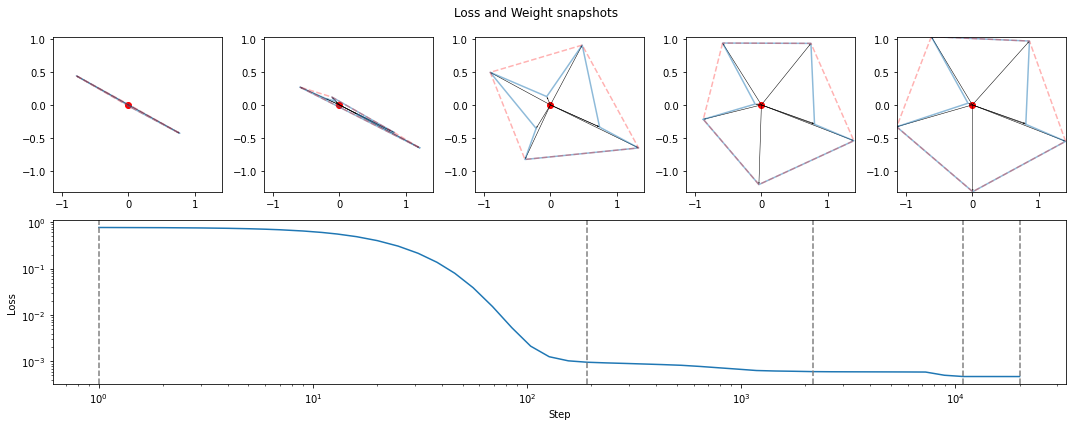

In [9]:
NUM_FEATURES = 8
NUM_HIDDEN_UNITS = 2
NUM_SAMPLES = 1000  
NUM_EPOCHS = 20000
INIT_KGON = 2
NUM_OBSERVATIONS = 50

STEPS = sorted(list(set(np.logspace(0, np.log10(NUM_EPOCHS), NUM_OBSERVATIONS).astype(int))))
PLOT_STEPS = [min(STEPS, key=lambda s: abs(s-i)) for i in [0, 200, 2000, 10000, NUM_EPOCHS - 1]]
PLOT_INDICES = [STEPS.index(s) for s in PLOT_STEPS]

logs, weights = create_and_train(NUM_FEATURES, NUM_HIDDEN_UNITS, num_samples=NUM_SAMPLES, log_ivl=STEPS, batch_size=100, lr=0.01, num_epochs=NUM_EPOCHS, init_kgon=INIT_KGON, init_zerobias=False, seed=1)

weights_to_plot = [weights[i]['embedding.weight'] for i in PLOT_INDICES]
losses = [logs.loc[logs['step'] == s, 'loss'].values[0] for s in STEPS]
plot_losses_and_polygons(STEPS, losses, PLOT_STEPS, weights_to_plot)
plt.show()

## Analysis

### Local learning coefficient estimation

See the other notebooks for more details on learning coefficient estimation. 

In [10]:
# Sweep SGLD hyperparameters

NUM_SAMPLES_TEST = 200
NUM_DRAWS_SGLD = 100
NUM_CHAINS_SGLD = 5

dataset = SyntheticBinaryValued(NUM_SAMPLES_TEST, NUM_FEATURES, 1)
dataset_double = TensorDataset(dataset.data, dataset.data)
model = ToyAutoencoder(NUM_FEATURES, NUM_HIDDEN_UNITS, final_bias=True)

def sweep_lambdahat_estimation_hyperparams(
        model, 
        dataset, 
        device=DEVICE,
        sgld_kwargs=None,
        num_draws=NUM_DRAWS_SGLD,
        num_chains=NUM_CHAINS_SGLD
):
    observations = []
    hyperparam_combos = list(itertools.product([1, 10, 30, 100, 300], [1e-5, 1e-4, 1e-3, 1e-2]))

    sgld_kwargs = sgld_kwargs or {}
    sgld_kwargs.setdefault("num_samples", len(dataset))
    sgld_kwargs.setdefault("elasticity", 1.)

    for batch_size, lr in tqdm(hyperparam_combos, desc="Sweeping hyperparameters",):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        model.load_state_dict({k: torch.Tensor(v) for k, v in weights[-1].items()})

        observation = estimate_learning_coeff_with_summary(
                model,
                loader,
                F.mse_loss,
                device=device,
                sampling_method=SGLD,
                optimizer_kwargs={
                    "lr": lr,
                    **sgld_kwargs
                },
                verbose=False,
                num_draws=num_draws,
                num_chains=num_chains,
                online=True
            )

        for t_sgld in range(num_draws):
            observations.append({
                    "llc": observation["llc/means"][t_sgld].item(),
                    "llc/std": observation["llc/stds"][t_sgld].item(),
                    "batch_size": batch_size,
                    "lr": lr,
                    "t_sgld": t_sgld,
                    "llc_type": "mean",
                    "loss": observation["loss/trace"][:, t_sgld].mean().item()
                })
            
            for llc_type in range(num_chains):
                observations.append({
                    "llc": observation["llc/trace"][llc_type, t_sgld].item(),
                    "batch_size": batch_size,
                    "lr": lr,
                    "t_sgld": t_sgld,
                    "llc_type": str(llc_type),
                    "loss": observation["loss/trace"][llc_type, t_sgld].item(),
                })

    return pd.DataFrame(observations)

lambdahat_sweep_df = sweep_lambdahat_estimation_hyperparams(model, dataset_double)
lambdahat_sweep_df

Sweeping hyperparameters: 100%|██████████| 20/20 [07:02<00:00, 21.10s/it]


,llc,llc/std,batch_size,lr,t_sgld,llc_type,loss
0,0.000000,0.0,1,0.00001,0,mean,0.027350
1,0.000000,NaN,1,0.00001,0,0,0.005019
2,0.000000,NaN,1,0.00001,0,1,0.000058
3,0.000000,NaN,1,0.00001,0,2,0.001096
4,0.000000,NaN,1,0.00001,0,3,0.125561
...,...,...,...,...,...,...,...
11995,4.711228,NaN,300,0.01000,99,0,0.120495
11996,4.414537,NaN,300,0.01000,99,1,0.257048
11997,4.700046,NaN,300,0.01000,99,2,0.195992
11998,3.756812,NaN,300,0.01000,99,3,0.098800


/Users/Jesse/Projects/devinterp/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
<ipython-input-120-6842c8ece04d>:29: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


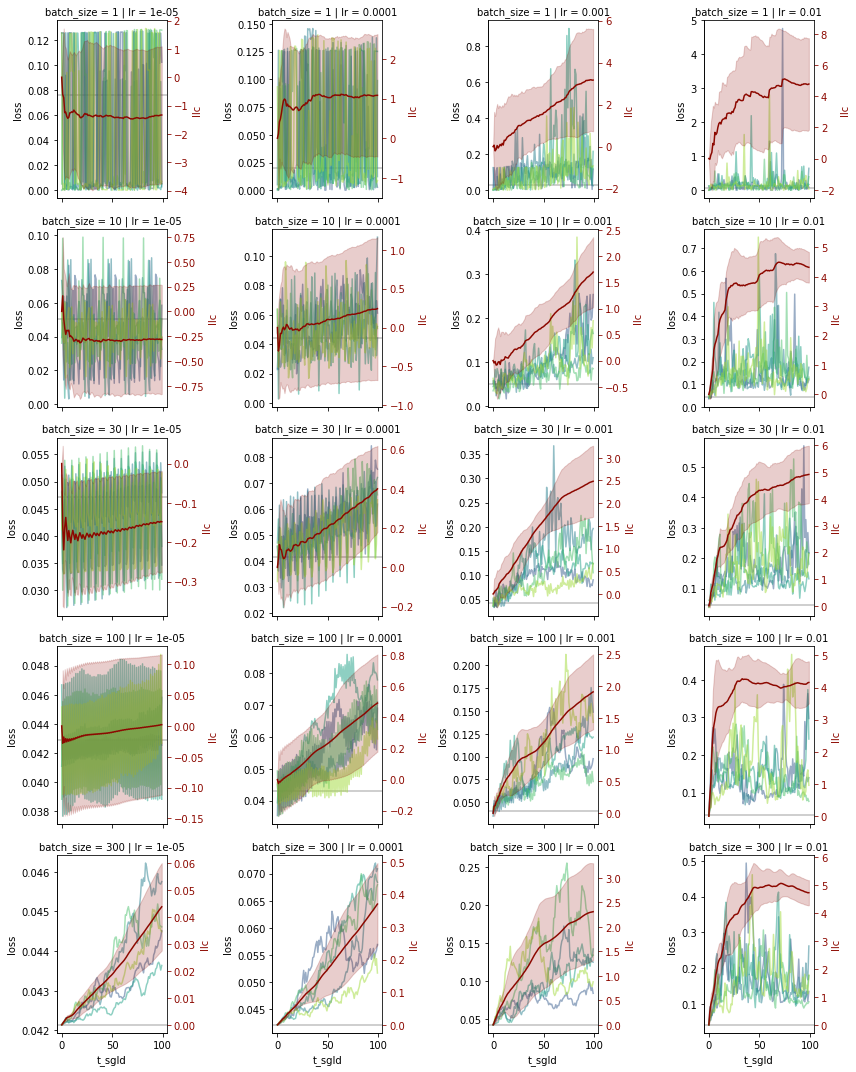

In [120]:
# Plot SGLD hyperparameter grid sweep

import seaborn as sns

def plot_lambdahat_estimation_hyperparams(observations_df):
    def plot_losses(data, **kwargs):
        if kwargs["label"] == "mean":
            plt.axhline(data.loc[data.t_sgld == 0, "loss"].values[0], color="grey", alpha=0.5)
            return
    
        _data = data.loc[data.llc_type != "mean"]
        sns.lineplot(_data, x="t_sgld", y="loss", **kwargs, alpha=0.5)

    def plot_llcs(data, **kwargs):
        if kwargs["label"] != "mean":
            return
        _data = data.loc[data.llc_type == "mean"]
        ax = plt.twinx()
        kwargs.pop("color")
        color = sns.color_palette("dark")[3]
        ax.plot(_data['t_sgld'], _data['llc'], color=color, **kwargs)
        ax.fill_between(_data['t_sgld'], _data['llc'] - _data['llc/std'], _data['llc'] + _data['llc/std'], color=color, alpha=0.2)
        ax.set_ylabel("llc", color=color)
        ax.tick_params(axis='y', colors=color)

    g = sns.FacetGrid(observations_df, col="lr", row="batch_size", hue="llc_type", palette="viridis", sharey=False)
    g.map_dataframe(plot_losses)
    g.map_dataframe(plot_llcs)

    g.fig.set_facecolor('white')
    g.fig.tight_layout()

    plt.show()

plot_lambdahat_estimation_hyperparams(lambdahat_sweep_df)

### Covariance Analysis

The idea behind covariance analysis is to look at the covariance between weights across a bunch of different trajectories and how this changes over time. 

Based on literature from developmental biology ([Freedman et al. 2023](https://journals.biologists.com/dev/article/150/11/dev201280/312613/A-dynamical-systems-treatment-of-transcriptomic)), we expect transitions to be associated with discontinuous increases in the maximal eigenvalues of the covariance matrix. Moreover, by looking at the associated eigenvectors, we can get a sense of how the weights are involved in these transitions, that is, "where the circuits are forming."

**A note on tractability:** These models are small enough that we can handle the full covariance matrix, but in general we'll have to consider simplifications like looking at covariances within a specific layer. In the same vein, we will generally consider only a subset of the covariance eigenspectrum, e.g., the largest-K eigenvalues, which can be cheaply estimated using power iteration.

**Versus SGLD estimation:** In principle, we could perform covariance analysis over the weights sampled by SGLD. Unlike SGLD-based sampling for lambdahat estimation, we'll want to include a larger thinning factor because weights at more of risk for autocorrelation. For reasons we'll flesh out in the future, we think it's probably best to do covariance across different trajectories *at the same point in time*. This means drawing only one sample per chain. We'll want to sample more and shorter chains. 

In [11]:

from typing import List
from devinterp.slt.callback import ChainCallback
from devinterp.slt.cov import WeightAccessor
from scipy.sparse.linalg import eigsh


class CovarianceAccumulator(ChainCallback):
    """
    A callback to iteratively compute and store the covariance matrix of model weights.
    For use with `estimate`. 

    Attributes:
        num_weights (int): Total number of weights.
        first_moment (torch.Tensor): First moment of weights.
        second_moment (torch.Tensor): Second moment of weights.
        num_draws (int): Number of draws made to accumulate moments.
        accessors (List[WeightAccessor]): Functions to access model weights.
        num_evals (int): Number of eigenvalues to compute.
    """
    def __init__(self, num_draws_per_chain: int, num_chains: int, num_weights: int, accessors: List[WeightAccessor], device = "cpu", num_evals=3):
        """
        Initialize the accumulator.
        """        
        self.num_weights = num_weights
        self.first_moment = torch.zeros(num_weights, device=device)
        self.second_moment = torch.zeros(num_weights, num_weights, device=device)
        self.num_draws = num_draws_per_chain * num_chains
        self.accessors = accessors
        self.num_evals = num_evals
        self.is_finished = False

    def accumulate(self, model: nn.Module):
        """Accumulate moments from model weights."""
        assert not self.is_finished, "Cannot accumulate after finalizing."

        weights = torch.cat([accessor(model).view((-1,)) for accessor in self.accessors])
        self.first_moment += weights / self.num_draws
        self.second_moment += torch.outer(weights, weights) / (self.num_draws - 1)
        # print(self.first_moment.mean(), self.second_moment.mean())

    def finalize(self):
        """Finalize the moments by dividing by the number of draws."""
        self.is_finished = True

    def reset(self):
        """Reset the accumulator."""
        self.first_moment.zero_()
        self.second_moment.zero_()
        self.is_finished = False

    def to_matrix(self):
        """Convert the moments to a covariance matrix."""
        return self.second_moment - (self.num_draws / (self.num_draws - 1)) * torch.outer(self.first_moment, self.first_moment)

    def to_eigen(self, include_matrix=False):
        """Convert the covariance matrix to pairs of eigenvalues and vectors."""
        cov = self.to_matrix().detach().cpu().numpy()
        evals, evecs = eigsh(cov, k=self.num_evals, which='LM')

        results = {
            "evals": evals,
            "evecs": evecs
        }

        if include_matrix:
            results["matrix"] = cov

        return results

    def sample(self):
        return self.to_eigen(include_matrix=True)
        
    def __call__(self, model):
        self.accumulate(model)

#### Calibrating Covariance Estimation

As mentioned, we're currently interested in using covariance analysis over SGD trajectories rather than local posterior samples. By default, we recommend setting hyperparameters like sampling noise and localization strength to match the original SGD hyperparameters used during training (i.e., set them equal to zero). 

First, let's see what difference it makes whether we use SGD or SGLD. We'll sweep over different batch sizes and interpolate between zero injected Gaussian noise (SGD) and standard SGLD (noise = 1.0). We'll use a localization strength of 0.0 for now.

In [14]:
# Sweep covariance estimation hyperparameters

NUM_DRAWS_COV = 1
NUM_BURNIN_COV = 10
NUM_CHAINS_COV = 50
NUM_EIGVALS_COV = 3

def sweep_covariance_estimation_hyperparams(
        model, 
        dataset, 
        steps, 
        checkpoints, 
        grid: dict,
        device=DEVICE, 
        sgld_kwargs=None,
        sampling_kwargs=None,
):
    observations = []
    accessors = {
        "weight": lambda model: model.embedding.weight,
        "bias": lambda model: model.unembedding.bias,
    }
    num_weights = sum([v(model).numel() for v in accessors.values()])
    hyperparam_combos = list(itertools.product(*grid.values()))

    sgld_kwargs = sgld_kwargs or {}
    sgld_kwargs.setdefault("noise_level", 1.)
    sgld_kwargs.setdefault("num_samples", len(dataset))
    sgld_kwargs.setdefault("elasticity", 0.)
    sgld_kwargs.setdefault("lr", 0.01)

    loader_kwargs = {"batch_size": 100}

    sampling_kwargs = sampling_kwargs or {}
    sampling_kwargs.setdefault("num_draws", NUM_DRAWS_COV)
    sampling_kwargs.setdefault("num_chains", NUM_CHAINS_COV)
    sampling_kwargs.setdefault("num_burnin_steps", NUM_BURNIN_COV)
    sampling_kwargs.setdefault("num_evals", NUM_EIGVALS_COV)

    for i, hyperparam_values in tqdm(enumerate(hyperparam_combos), total=len(hyperparam_combos), desc="Sweeping hyperparameters"):
        torch.manual_seed(i)
        hyperparams = dict(zip(grid.keys(), hyperparam_values))

        _sgld_kwargs = sgld_kwargs.copy()    
        _loader_kwargs = loader_kwargs.copy()
        _sampling_kwargs = sampling_kwargs.copy()

        for key in hyperparams:
            if key in _sgld_kwargs:
                _sgld_kwargs[key] = hyperparams[key]
            elif key in _loader_kwargs:
                _loader_kwargs[key] = hyperparams[key]
            elif key in _sampling_kwargs:
                _sampling_kwargs[key] = hyperparams[key]
            else:
                raise ValueError(f"Unknown hyperparameter {key}")

        loader = DataLoader(dataset, shuffle=True, **_loader_kwargs)
        
        callbacks = [
            CovarianceAccumulator(_sampling_kwargs["num_draws"], _sampling_kwargs["num_chains"], num_weights, list(accessors.values()), device=device, num_evals=_sampling_kwargs.pop("num_evals")),
        ]

        for step, checkpoint in tqdm(zip(steps, checkpoints), desc="Sweeping checkpoints", total=len(steps)):
            model.load_state_dict({k: torch.Tensor(v) for k, v in checkpoint.items()})

            observation = estimate_learning_coeff_with_summary(
                model,
                loader,
                F.mse_loss,
                device=device, # type: ignore
                sampling_method=SGLD,
                optimizer_kwargs=_sgld_kwargs,
                verbose=False,
                callbacks=callbacks,
                seed=i * _sampling_kwargs["num_chains"],
                **_sampling_kwargs
            )

            evals, _, cov_matrix = observation.pop("evals"), observation.pop("evecs"), observation.pop("matrix")

            for j, eval in enumerate(evals):
                observations.append({
                    "step": step,
                    "eval": eval,
                    "eval_idx": j,
                    **observation,
                    **_loader_kwargs,
                    **_sgld_kwargs,
                    **_sampling_kwargs,
                })

            for callback in callbacks:
                callback.reset()

    observations_df = pd.DataFrame(observations)
    return observations_df

model = ToyAutoencoder(NUM_FEATURES, NUM_HIDDEN_UNITS, final_bias=True)
covariance_estimation_sweep_df = sweep_covariance_estimation_hyperparams(
    model, dataset_double, STEPS, weights, 
    grid={"batch_size": [1, 10, 100], "noise_level": [0., 0.5, 1.]}
)
covariance_estimation_sweep_df

Sweeping hyperparameters: 100%|██████████| 9/9 [13:25<00:00, 89.49s/it]


,step,eval,eval_idx,llc/mean,llc/std,llc-chain/0,llc-chain/1,llc-chain/2,llc-chain/3,llc-chain/4,...,llc-chain/49,loss/trace,batch_size,noise_level,num_samples,elasticity,lr,num_draws,num_chains,num_burnin_steps
0,1,0.557788,0,-21.799477,213.964127,0.0,249.686783,-81.673912,492.604523,-51.313675,...,-208.660233,"[[30.885153], [37.499752], [28.721481], [43.93...",1,0.0,200,0.0,0.01,1,50,10
1,1,1.168303,1,-21.799477,213.964127,0.0,249.686783,-81.673912,492.604523,-51.313675,...,-208.660233,"[[30.885153], [37.499752], [28.721481], [43.93...",1,0.0,200,0.0,0.01,1,50,10
2,1,1.946605,2,-21.799477,213.964127,0.0,249.686783,-81.673912,492.604523,-51.313675,...,-208.660233,"[[30.885153], [37.499752], [28.721481], [43.93...",1,0.0,200,0.0,0.01,1,50,10
3,2,0.549335,0,-21.433111,212.173370,0.0,249.330612,-80.707695,492.691559,-50.691612,...,-206.812973,"[[30.721909], [37.327072], [28.583834], [43.77...",1,0.0,200,0.0,0.01,1,50,10
4,2,1.154158,1,-21.433111,212.173370,0.0,249.330612,-80.707695,492.691559,-50.691612,...,-206.812973,"[[30.721909], [37.327072], [28.583834], [43.77...",1,0.0,200,0.0,0.01,1,50,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,16340,0.412326,1,2.131871,3.673907,0.0,1.145357,2.140364,-1.202688,-1.436066,...,-0.675476,"[[0.11877477], [0.1491171], [0.17547642], [0.0...",100,1.0,200,0.0,0.01,1,50,10
1238,16340,0.455593,2,2.131871,3.673907,0.0,1.145357,2.140364,-1.202688,-1.436066,...,-0.675476,"[[0.11877477], [0.1491171], [0.17547642], [0.0...",100,1.0,200,0.0,0.01,1,50,10
1239,20000,0.326115,0,2.160537,3.682115,0.0,1.119130,2.214218,-1.163888,-1.414396,...,-0.644892,"[[0.11808541], [0.14773293], [0.17674357], [0....",100,1.0,200,0.0,0.01,1,50,10
1240,20000,0.412287,1,2.160537,3.682115,0.0,1.119130,2.214218,-1.163888,-1.414396,...,-0.644892,"[[0.11808541], [0.14773293], [0.17674357], [0....",100,1.0,200,0.0,0.01,1,50,10


Let's plot the results using a seaborn `FacetGrid`. Each subgraph shows the values of the three largest covariance eigenvalues over training time (with indices in increasing order). Each subgraph corresponds to a unique combination of batch size and noise level. The left column represents SGD trajectories. The right column represents SGLD trajectories (without localization). 

We see that indeed the SGLD-based covariance analysis seems to miss the last transition (while this shows up as a bump in the SGD-based analysis). 

/Users/Jesse/Projects/devinterp/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
<ipython-input-17-61ff063377ad>:11: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


<Figure size 1080x432 with 0 Axes>

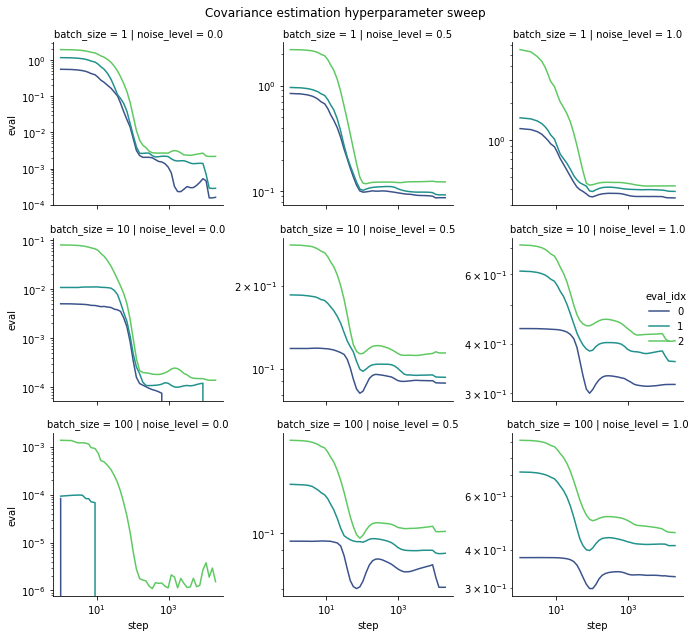

In [17]:
def plot_covariance_estimation_hyperparam_sweep(observations_df, y="eval", row="batch_size", col="noise_level", hue="eval_idx"):
    fig = plt.figure(figsize=(15, 6))

    g = sns.FacetGrid(observations_df, col=col, row=row, hue=hue, palette="viridis", sharey=False)
    g.map_dataframe(sns.lineplot, x="step", y=y)
    g.add_legend()
    g.set(xscale="log", yscale="log")
    # g.set(xscale="log", yscale="linear")

    plt.suptitle("Covariance estimation hyperparameter sweep")
    g.fig.tight_layout()
    plt.show()

covariance_estimation_sweep_df
plot_covariance_estimation_hyperparam_sweep(covariance_estimation_sweep_df)
# plot_covariance_estimation_hyperparam_sweep(covariance_estimation_sweep_df, y="true_eval")

#### Calibrating Burn-in Period

We'll want to use a burn-in period to avoid including the initial transient in our analysis. We'll want to use a burn-in period that's long enough to ensure that the weights have diverged from their initial values (and thus that there is any meaningful covariance to analyze).

To avoid having to repeat the covariance analysis for a bunch of different burn-in periods, we'll follow an online approach where we compute a novel covariance estimate for increasing numbers of sampling time steps.

In [183]:
# Let's try to understand the dependence of the covariance analysis on the number of burnin steps

NUM_STEPS_BW_DRAWS_COV = 5

class OnlineCovarianceAccumulator(ChainCallback):
    """
    A callback to iteratively compute and store the covariance matrix of model weights.
    For use with `estimate`. 

    Attributes:
        num_weights (int): Total number of weights.
        first_moment (torch.Tensor): First moment of weights.
        second_moment (torch.Tensor): Second moment of weights.
        num_draws (int): Number of draws made to accumulate moments.
        accessors (List[WeightAccessor]): Functions to access model weights.
        num_evals (int): Number of eigenvalues to compute.
    """
    def __init__(self, num_draws_per_chain: int, num_chains: int, num_weights: int, accessors: List[WeightAccessor], device = "cpu", num_evals=3):
        """
        Initialize the accumulator.
        """        
        self.num_weights = num_weights
        self.first_moment = torch.zeros(num_draws_per_chain, num_weights, device=device)
        self.second_moment = torch.zeros(num_draws_per_chain, num_weights, num_weights, device=device)
        self.num_draws_per_chain = num_draws_per_chain
        self.num_chains = num_chains
        self.accessors = accessors
        self.num_evals = num_evals
        self.is_finished = False

    def accumulate(self, model: nn.Module, draw: int):
        """Accumulate moments from model weights."""
        assert not self.is_finished, "Cannot accumulate after finalizing."

        weights = torch.cat([accessor(model).view((-1,)) for accessor in self.accessors])
        self.first_moment[draw] += weights / self.num_chains
        self.second_moment[draw] += torch.outer(weights, weights) / (self.num_chains - 1)
        # print(self.first_moment.mean(), self.second_moment.mean())

    def finalize(self):
        """Finalize the moments by dividing by the number of draws."""
        self.is_finished = True

    def reset(self):
        """Reset the accumulator."""
        self.first_moment.zero_()
        self.second_moment.zero_()
        self.is_finished = False

    def to_matrix(self):
        """Convert the moments to a covariance matrix."""
        covariance = self.second_moment

        for d in range(self.num_draws_per_chain):
            first_moment = self.first_moment[d]
            covariance[d] -= (self.num_chains / (self.num_chains - 1)) * torch.outer(first_moment, first_moment)

        return covariance
    
    def to_eigen(self, include_matrix=False):
        """Convert the covariance matrix to pairs of eigenvalues and vectors."""
        cov = self.to_matrix().detach().cpu().numpy()

        evals = np.zeros((self.num_evals, self.num_draws_per_chain))
        evecs = np.zeros((self.num_evals, self.num_draws_per_chain, self.num_weights))

        for d in range(self.num_draws_per_chain):
            _evals, _evecs = eigsh(cov[d], k=self.num_evals, which='LM')
            evals[:, d], evecs[:, d, :] = _evals, _evecs.T

        results = {
            "evals": evals,
            "evecs": evecs
        }

        if include_matrix:
            results["matrix"] = cov

        return results

    def sample(self):
        return self.to_eigen(include_matrix=True)
        
    def __call__(self, model, draw):
        self.accumulate(model, draw)


def sweep_online_covariance_estimation_hyperparams(
        model, 
        dataset, 
        steps, 
        checkpoints, 
        grid: dict,
        device=DEVICE, 
        sgld_kwargs=None,
        loader_kwargs=None,
        sampling_kwargs=None,
):
    observations = []
    accessors = {
        "weight": lambda model: model.embedding.weight,
        "bias": lambda model: model.unembedding.bias,
    }
    num_weights = sum([v(model).numel() for v in accessors.values()])
    hyperparam_combos = list(itertools.product(*grid.values()))

    sgld_kwargs = sgld_kwargs or {}
    sgld_kwargs.setdefault("noise_level", 1.)
    sgld_kwargs.setdefault("num_samples", len(dataset))
    sgld_kwargs.setdefault("elasticity", 0.)
    sgld_kwargs.setdefault("lr", 0.01)

    loader_kwargs = loader_kwargs or {"batch_size": 100}

    sampling_kwargs = sampling_kwargs or {}
    sampling_kwargs.setdefault("num_draws", NUM_DRAWS_COV)
    sampling_kwargs.setdefault("num_chains", NUM_CHAINS_COV)
    sampling_kwargs.setdefault("num_burnin_steps", NUM_BURNIN_COV)
    sampling_kwargs.setdefault("num_steps_bw_draws", NUM_STEPS_BW_DRAWS_COV)
    

    for i, hyperparam_values in tqdm(enumerate(hyperparam_combos), total=len(hyperparam_combos), desc="Sweeping hyperparameters"):
        torch.manual_seed(i)
        hyperparams = dict(zip(grid.keys(), hyperparam_values))

        _sgld_kwargs = sgld_kwargs.copy()    
        _loader_kwargs = loader_kwargs.copy()
        _sampling_kwargs = sampling_kwargs.copy()

        for key in hyperparams:
            if key in _sgld_kwargs:
                _sgld_kwargs[key] = hyperparams[key]
            elif key in _loader_kwargs:
                _loader_kwargs[key] = hyperparams[key]
            elif key in _sampling_kwargs:
                _sampling_kwargs[key] = hyperparams[key]
            else:
                raise ValueError(f"Unknown hyperparameter {key}")

        loader = DataLoader(dataset, shuffle=True, **_loader_kwargs)
        
        callbacks = [
            OnlineCovarianceAccumulator(_sampling_kwargs["num_draws"], _sampling_kwargs["num_chains"], num_weights, list(accessors.values()), device=device),
        ]

        for step, checkpoint in tqdm(zip(steps, checkpoints), desc="Sweeping checkpoints", total=len(steps)):
            model.load_state_dict({k: torch.Tensor(v) for k, v in checkpoint.items()})

            observation = estimate_learning_coeff_with_summary(
                model,
                loader,
                F.mse_loss,
                device=device, # type: ignore
                sampling_method=SGLD,
                optimizer_kwargs=_sgld_kwargs,
                verbose=False,
                callbacks=callbacks,
                seed=i * _sampling_kwargs["num_chains"],
                **_sampling_kwargs
            )

            evals, _, _ = observation.pop("evals"), observation.pop("evecs"), observation.pop("matrix")

            for draw in range(_sampling_kwargs["num_draws"]):
                for j, eval in enumerate(evals[:, draw]):
                    observations.append({
                        "step": step,
                        "eval": eval,
                        "eval_idx": j,
                        "draw_idx": draw,
                        **observation,
                        **_loader_kwargs,
                        **_sgld_kwargs,
                        **_sampling_kwargs,
                    })

            for callback in callbacks:
                callback.reset()

    observations_df = pd.DataFrame(observations)
    return observations_df

model = ToyAutoencoder(NUM_FEATURES, NUM_HIDDEN_UNITS, final_bias=True)
online_covariance_estimation_sweep_df = sweep_online_covariance_estimation_hyperparams(
    model, dataset_double, steps, weights,
    loader_kwargs={"batch_size": 10},
    sampling_kwargs={"num_burnin_steps": 0, "num_steps_bw_draws": 5},
    grid={"num_draws": [10], "num_chains": [5, 10, 20, 50, 100]}
)
online_covariance_estimation_sweep_df


Sweeping hyperparameters: 100%|██████████| 5/5 [22:24<00:00, 268.99s/it]


,step,eval,eval_idx,draw_idx,llc/mean,llc/std,llc-chain/0,llc-chain/1,llc-chain/2,llc-chain/3,...,llc-chain/90,llc-chain/91,llc-chain/92,llc-chain/93,llc-chain/94,llc-chain/95,llc-chain/96,llc-chain/97,llc-chain/98,llc-chain/99
0,1,0.058251,0,0,-2169.489258,16.380209,-2179.289307,-2169.051758,-2183.022461,-2138.040527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.103022,1,0,-2169.489258,16.380209,-2179.289307,-2169.051758,-2183.022461,-2138.040527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.172920,2,0,-2169.489258,16.380209,-2179.289307,-2169.051758,-2183.022461,-2138.040527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.419286,0,1,-2169.489258,16.380209,-2179.289307,-2169.051758,-2183.022461,-2138.040527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.767126,1,1,-2169.489258,16.380209,-2179.289307,-2169.051758,-2183.022461,-2138.040527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6895,20000,0.941534,1,8,4.894427,1.675066,6.974194,5.523967,4.352364,2.953346,...,5.800991,4.244707,4.63375,4.270407,2.097307,3.651935,3.831441,2.849233,3.092811,5.447573
6896,20000,1.074323,2,8,4.894427,1.675066,6.974194,5.523967,4.352364,2.953346,...,5.800991,4.244707,4.63375,4.270407,2.097307,3.651935,3.831441,2.849233,3.092811,5.447573
6897,20000,0.902547,0,9,4.894427,1.675066,6.974194,5.523967,4.352364,2.953346,...,5.800991,4.244707,4.63375,4.270407,2.097307,3.651935,3.831441,2.849233,3.092811,5.447573
6898,20000,0.992416,1,9,4.894427,1.675066,6.974194,5.523967,4.352364,2.953346,...,5.800991,4.244707,4.63375,4.270407,2.097307,3.651935,3.831441,2.849233,3.092811,5.447573


/Users/Jesse/Projects/devinterp/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
<ipython-input-172-61ff063377ad>:11: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


<Figure size 1080x432 with 0 Axes>

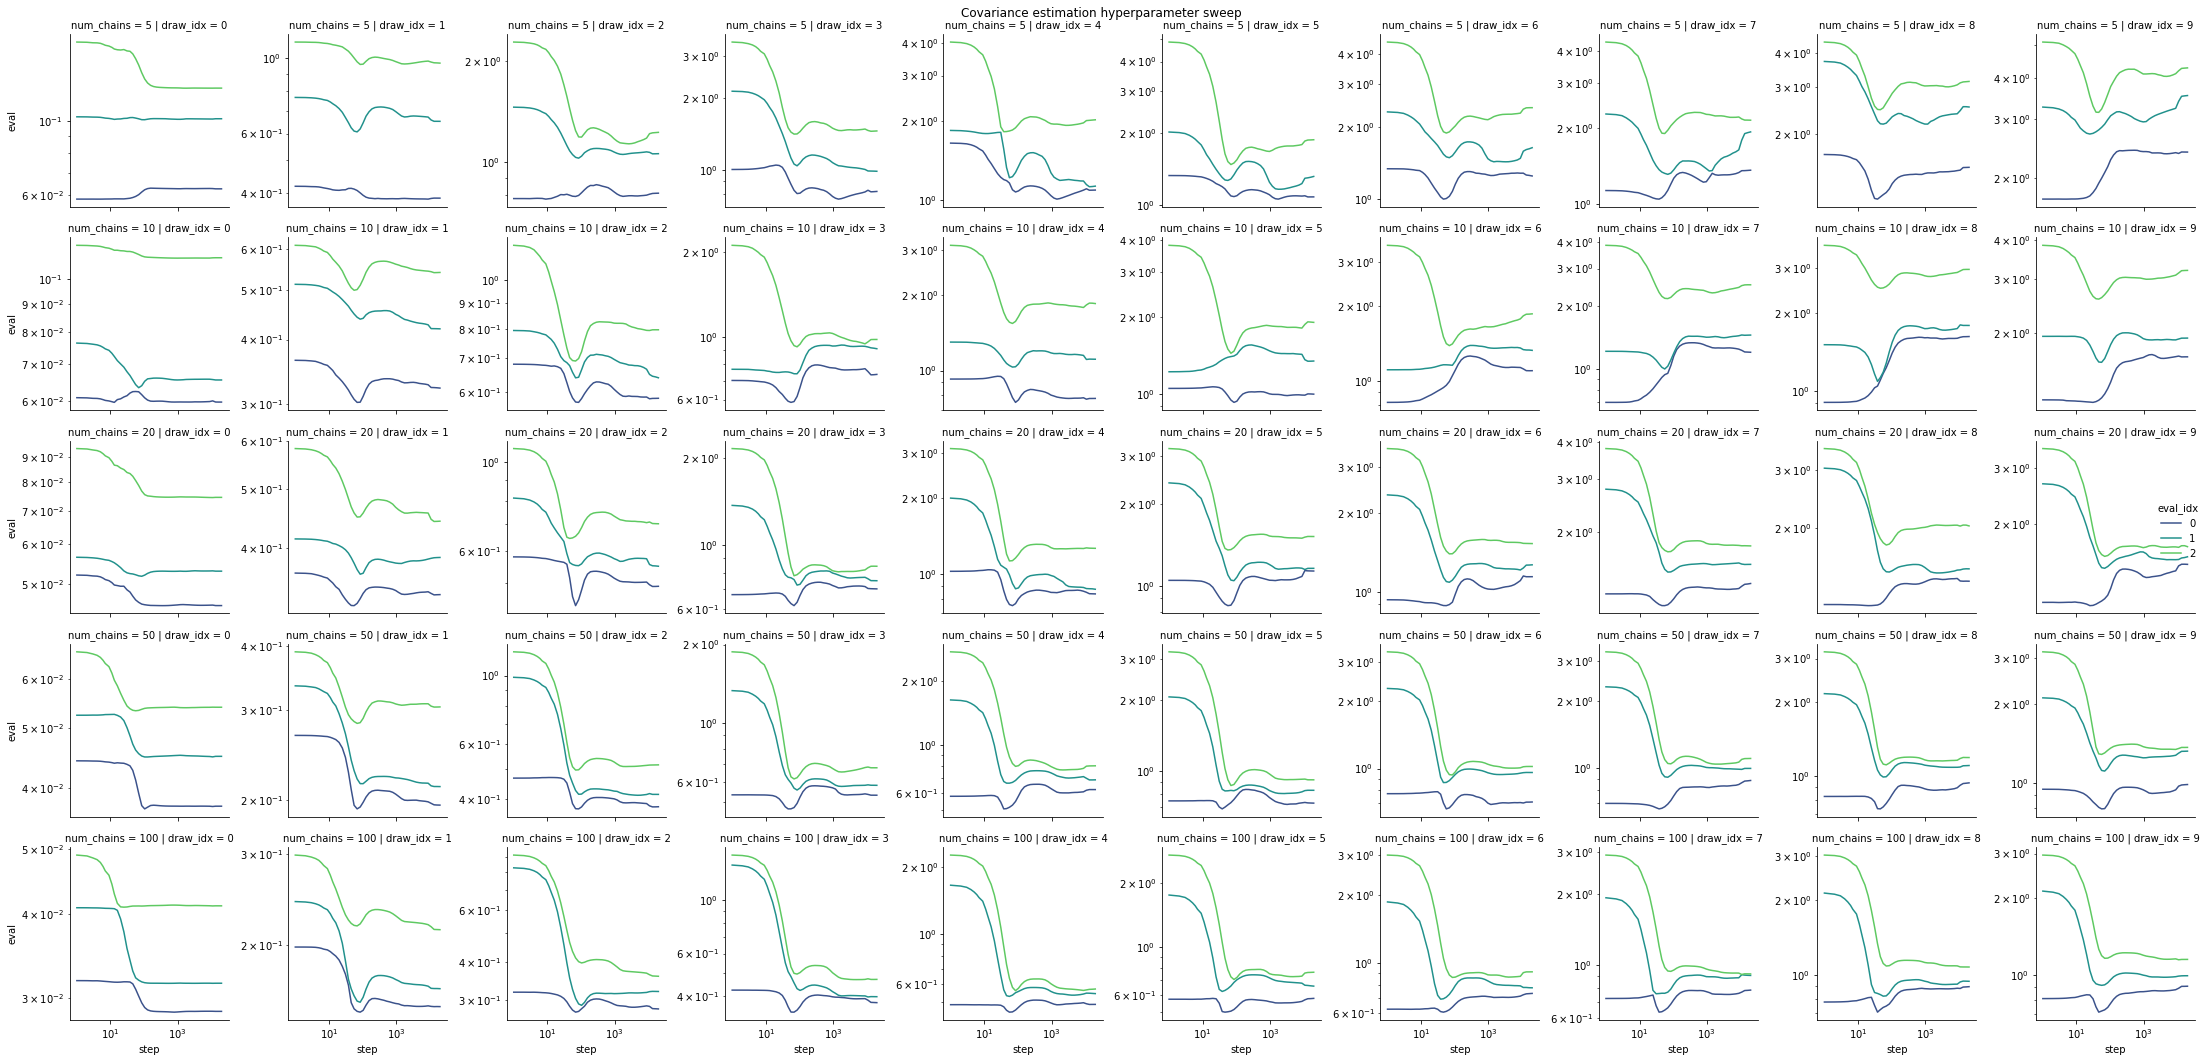

In [184]:
plot_covariance_estimation_hyperparam_sweep (online_covariance_estimation_sweep_df, col="draw_idx", row="num_chains")